In [1]:
import pandas as pd
import os

# Reading the dam occupancy dataset
occupancy_df = pd.read_excel("../data/raw/istanbul-dams-daily-occupancy-rates.xlsx")
occupancy_df["Date"] = pd.to_datetime(occupancy_df["Tarih"], dayfirst=True)
occupancy_df.drop(columns=["Tarih"], inplace=True)

# Reading the rainfall and consumption dataset
rainfall_df = pd.read_excel("../data/raw/istanbul-barajlarnda-yagis-ve-gunluk-tuketim-verileri.xlsx")
rainfall_df["Date"] = pd.to_datetime(rainfall_df["Tarih"], dayfirst=True)
rainfall_df.drop(columns=["Tarih"], inplace=True)

# Stripping any trailing whitespaces from column names
rainfall_df.columns = [col.strip() for col in rainfall_df.columns]

# Renaming the water consumption column to English
rainfall_df.rename(columns={"İstanbul günlük tüketim(m³/gün)": "Istanbul_Daily_Consumption"}, inplace=True)

# Replacing comma with dot and converting to float for all numeric columns
for col in rainfall_df.columns:
    if col != "Date":
        rainfall_df[col] = rainfall_df[col].astype(str).str.replace(",", ".").str.replace("%", "")
        rainfall_df[col] = pd.to_numeric(rainfall_df[col], errors='coerce')

# Merging the two datasets on the 'Date' column
merged_df = pd.merge(occupancy_df, rainfall_df, on="Date", how="inner")

# Forward filling missing values to ensure continuity
merged_df.ffill(inplace=True)

# Creating output directory if it doesn't exist
os.makedirs("../data/processed", exist_ok=True)

# Saving the merged dataset for further modeling
merged_df.to_csv("../data/processed/merged_multivariate_dataset.csv", index=False)

# Displaying confirmation
print("Merged dataset saved successfully. Shape:", merged_df.shape)


Merged dataset saved successfully. Shape: (4797, 23)


Data Cleaning

Missing Values:
 Unnamed: 11    4797
dtype: int64


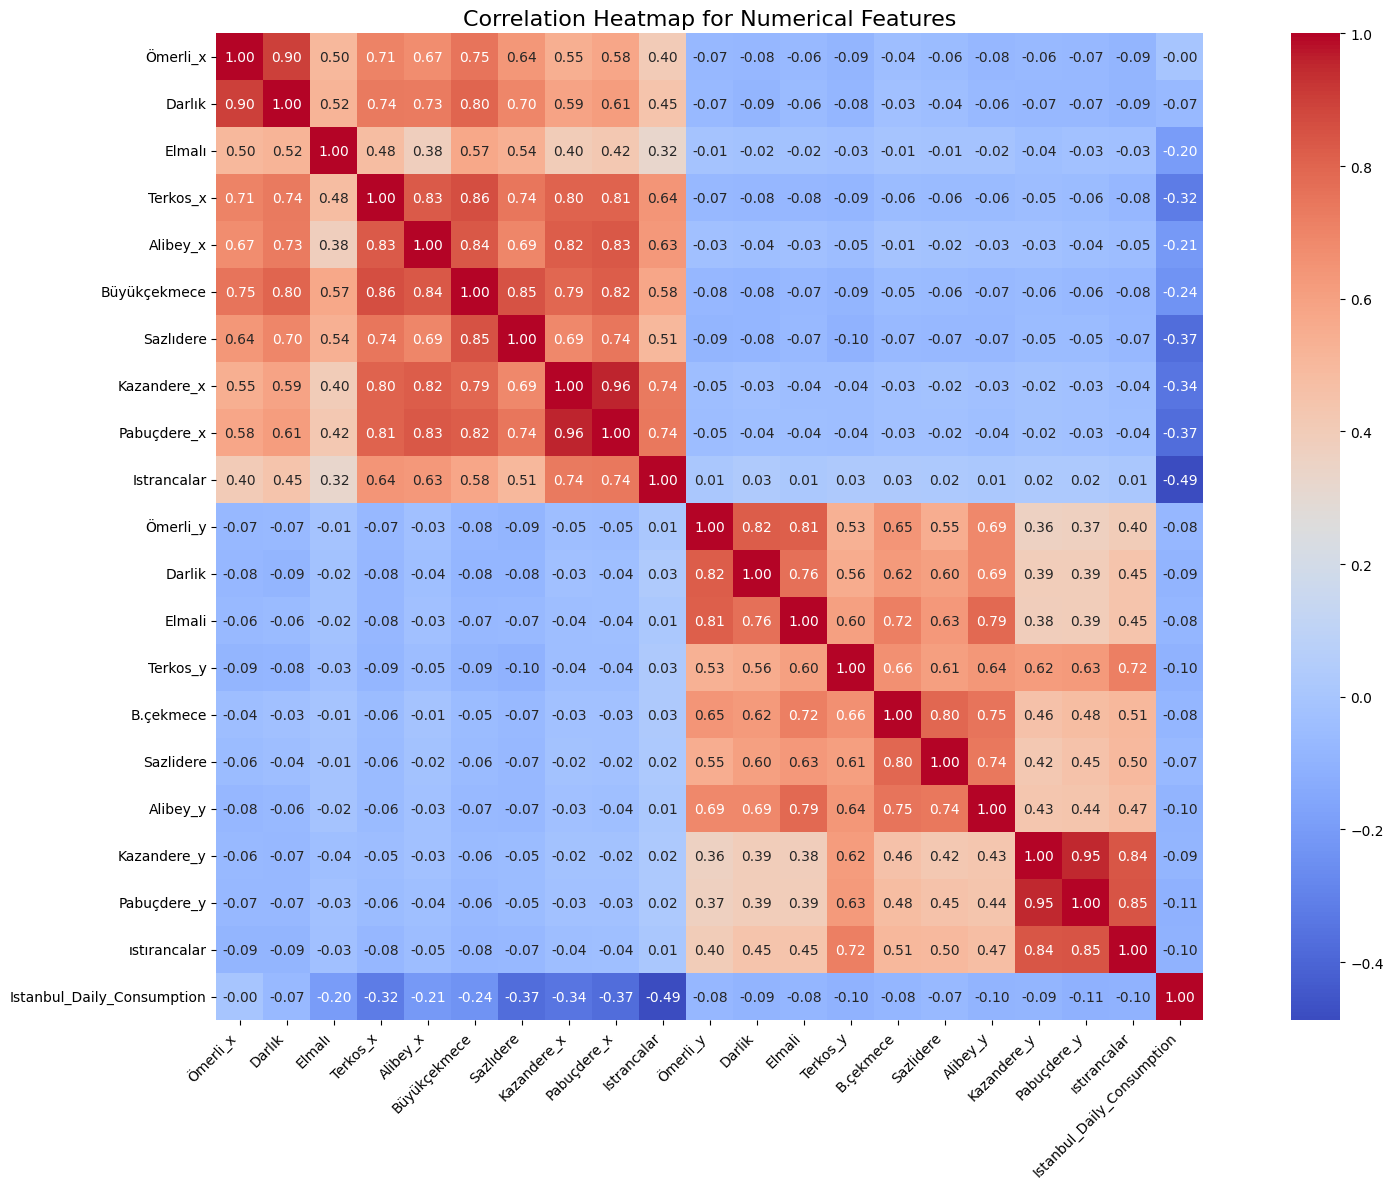

['Ömerli_x',
 'Darlık',
 'Elmalı',
 'Terkos_x',
 'Alibey_x',
 'Büyükçekmece',
 'Sazlıdere',
 'Kazandere_x',
 'Pabuçdere_x',
 'Istrancalar',
 'Date',
 'Ömerli_y',
 'Darlik',
 'Elmali',
 'Terkos_y',
 'B.çekmece',
 'Sazlidere',
 'Alibey_y',
 'Kazandere_y',
 'Pabuçdere_y',
 'ıstırancalar',
 'Istanbul_Daily_Consumption']

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the merged multivariate dataset
df = pd.read_csv("../data/processed/merged_multivariate_dataset.csv")

# Checking for missing values in the dataset
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Dropping unnecessary unnamed columns if exist
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Converting 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Creating a correlation heatmap for numerical features
plt.figure(figsize=(18, 12))
sns.heatmap(df.drop(columns=['Date']).corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap for Numerical Features", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


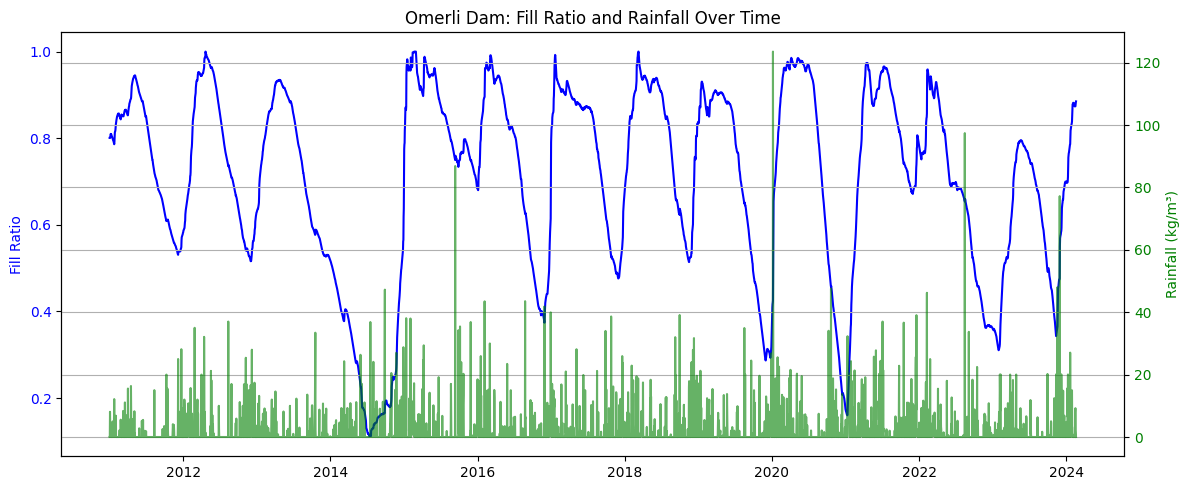

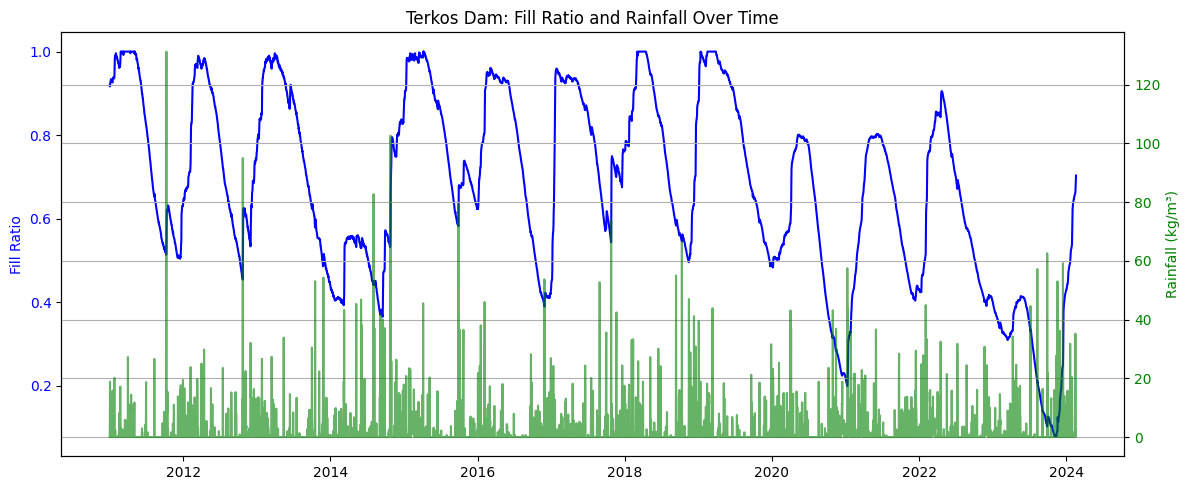

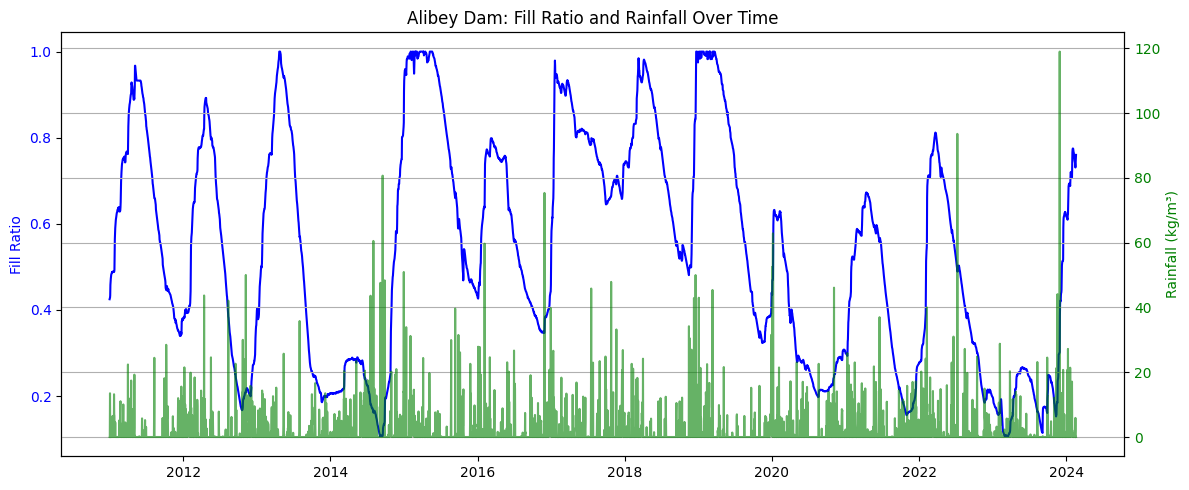

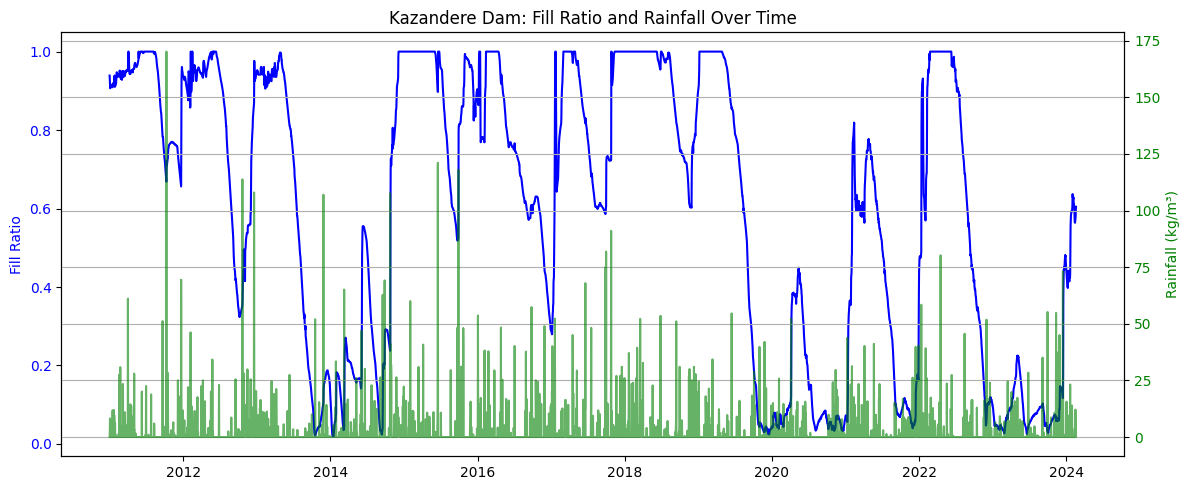

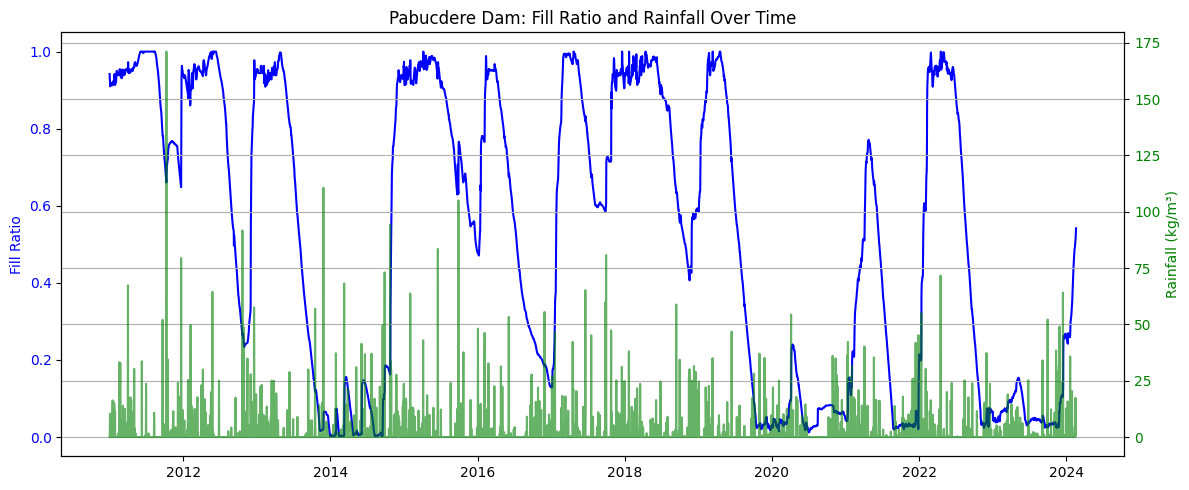

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
df.columns.tolist()
# Loading the cleaned multivariate dataset
df = pd.read_csv("../data/processed/merged_multivariate_dataset_cleaned.csv")

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Drop any unnamed columns if present
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns.tolist()
# Mapping each dam to its corresponding rainfall column
dam_rain_map = {
    'Omerli': 'Omerli_Rainfall',
    'Darlik': 'Darlik',
    'Elmali': 'Elmali',
    'Terkos': 'Terkos_Rainfall',
    'Buyukcekmece': 'B.cekmece',
    'Sazlidere': 'Sazlidere',
    'Alibey': 'Alibey_Rainfall',
    'Kazandere': 'Kazandere_Rainfall',
    'Pabucdere': 'Pabucdere_Rainfall',
    'Istrancalar': 'istirancalar'
}

# Plot only dams with both fill ratio and rainfall data
for dam, rain_col in dam_rain_map.items():
    fill_col = f"{dam}_Fill"
    
    if fill_col in df.columns and rain_col in df.columns:
        fig, ax1 = plt.subplots(figsize=(12, 5))
        
        ax1.plot(df['Date'], df[fill_col], label='Fill Ratio', color='blue')
        ax1.set_ylabel('Fill Ratio', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        ax2 = ax1.twinx()
        ax2.plot(df['Date'], df[rain_col], label='Rainfall', color='green', alpha=0.6)
        ax2.set_ylabel('Rainfall (kg/m³)', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        
        plt.title(f"{dam} Dam: Fill Ratio and Rainfall Over Time")
        fig.tight_layout()
        plt.grid(True)
        plt.show()
